In [2]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [21]:
# define different function
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input,sep='\t')
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['fit'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))]) 
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8)) 
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,reg):
    
    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='pairwise', 
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)
    
    # Fit model to data
    history = model.fit(learning_rate=.005,
                        epochs=1000,
                        batch_size=64,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    return model
def PlotTrain(model,test_set):
    # Get x and y
    x_test = test_set['ID'].values
    y_test = test_set['y'].values

    # Show training history
    print('On test data:')

    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
def PlotR2(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

    # Plot y_test vs. yhat_test
    fig, ax = plt.subplots(1,1)
    ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.4, label='test data')
    ax.set_xlabel('model prediction ($\hat{y}$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'performance ($R^2$={Rsq:.3})')
    plt.show()
def PlotGEnonlinearity(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict latent phentoype values (phi) on test data
    phi_test = model.x_to_phi(x_test)

    # Set phi lims and create grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 90% CI for each yhat
    q = [0.05, 0.95] #[0.16, 0.84]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])

    # Illustrate measurement process with GE curve
    ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y} = g(\phi)$')
    ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
    ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title('measurement process')
    ax.legend()

    # Fix up plot
    fig.tight_layout()
    plt.show()

#epi_map export
def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map

#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():               
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df


We now define a MAVE-NN model with pairwise G-P map and a Gaussian noise model. 

<ipython-input-21-da1dd33414cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain         pI  rep1_fit  rep2_fit       fit         y  \
0      798  NNKSEEL   HK68   4.531398  0.395971  0.125923  0.260947 -1.343439   
1      564  NSESETL   HK68   4.050028  0.029224  0.003061  0.016143 -4.126292   
2      863  NNRSKKS   HK68  11.166263  0.021724  0.110564  0.066144 -2.715916   
3      440  KDKGKTL   HK68   9.703024  0.047969  0.025266  0.036618 -3.307220   
4      674  NNKSEDS   HK68   4.370259  0.392947  3.797162  2.095054  0.739579   
..     ...      ...    ...        ...       ...       ...       ...       ...   
686    213  KSEGKDL   HK68   6.069006  0.049409  0.084788  0.067098 -2.701594   
687    445  NDKGEDL   HK68   4.050028  0.183048  0.279598  0.231323 -1.463941   
688    470  NDRSKTL   HK68   8.747731  0.012000  0.051857  0.031929 -3.444254   
689    467  NDKNKDS   HK68   5.959762  1.643482  0.690140  1.166811  0.154274   
690    819  NDRSKKL   HK68   9.994292  0.178842  0.184906  0.181874 -1.704442   

       set  
0    train  
1

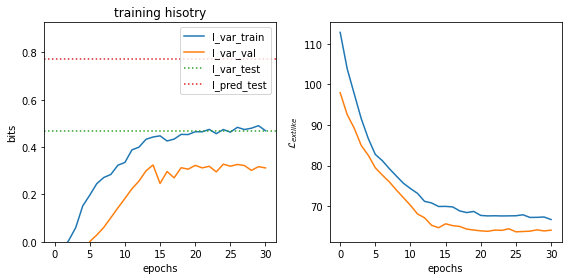

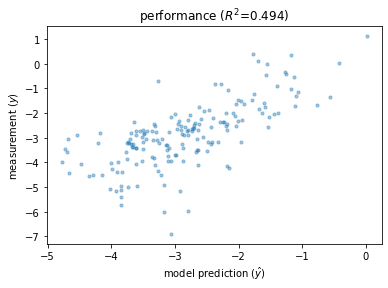

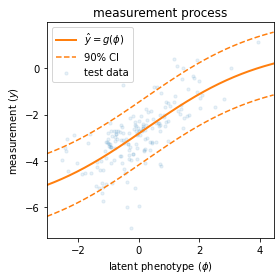

Model saved to these files:
	../result/HK68_epi.pickle
	../result/HK68_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.053979
1    1.0  2.0   K   N -0.162716
2    1.0  2.0   K   S -0.080361
3    1.0  2.0   N   D  0.195218
4    1.0  2.0   N   N -0.037770
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.308422
149  6.0  7.0   K   L -0.046987
150  6.0  7.0   K   S -0.085464
151  6.0  7.0   T   L  0.095548
152  6.0  7.0   T   S -0.022067

[153 rows x 5 columns]


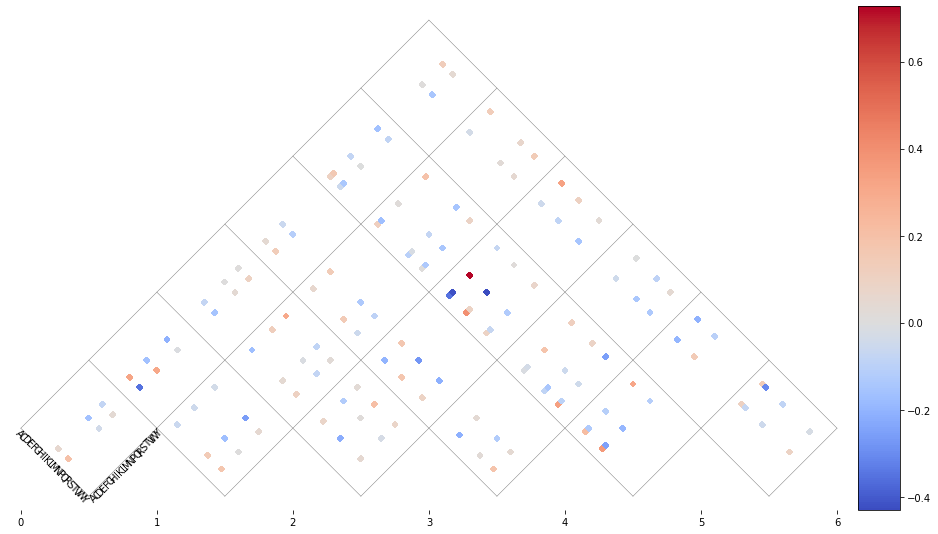

In [38]:
##Loading HK68 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68')
print(train_set)
model = Train_model(train_set,test_set,0.1)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/HK68_epi')
#model = mavenn.load('../result/HK68_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis
data = theta['theta_lclc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HK68_epi.csv')
print(epi_df)

<ipython-input-21-da1dd33414cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain         pI  rep1_fit  rep2_fit       fit         y  \
0      918  NSENKDL   Bk79   4.370259  0.180092  0.241080  0.210586 -1.557862   
1     1595  NNKNKES   Bk79   8.591073  0.056094  0.072701  0.064398 -2.742676   
2     1185  KSRSEES   Bk79   6.143238  0.600090  0.245354  0.422722 -0.861040   
3     1343  NNESEKL   Bk79   4.531398  1.185895  0.488736  0.837315 -0.177554   
4     1026  NDRGKKS   Bk79   9.994292  0.106584  0.153197  0.129890 -2.041066   
..     ...      ...    ...        ...       ...       ...       ...       ...   
686   1292  NSKGKKS   Bk79  10.302064  0.136431  0.063957  0.100194 -2.300646   
687   1439  NNEGKDS   Bk79   4.370259  0.097459  0.137828  0.117644 -2.140096   
688    893  KNESEKS   Bk79   6.142556  0.564542  0.482013  0.523278 -0.647643   
689   1156  NNESEDL   Bk79   4.050028  0.166381  0.246202  0.206291 -1.578467   
690   1208  NSESKDS   Bk79   4.370259  0.387294  0.747934  0.567614 -0.566314   

       set  
0    train  
1

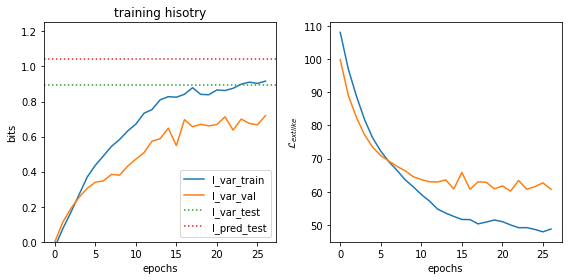

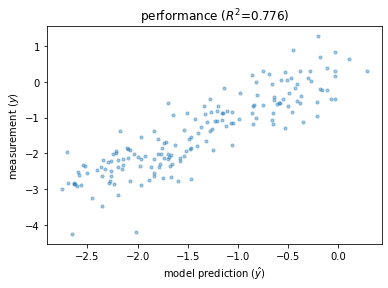

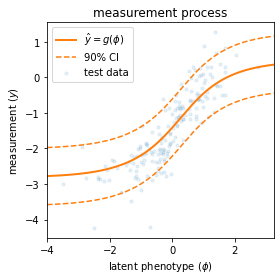

Model saved to these files:
	../result/Bk79_epi.pickle
	../result/Bk79_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.238992
1    1.0  2.0   K   N -0.252649
2    1.0  2.0   K   S -0.208443
3    1.0  2.0   N   D  0.036667
4    1.0  2.0   N   N -0.114188
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.067752
149  6.0  7.0   K   L  0.234542
150  6.0  7.0   K   S -0.157941
151  6.0  7.0   T   L -0.106081
152  6.0  7.0   T   S -0.107513

[153 rows x 5 columns]


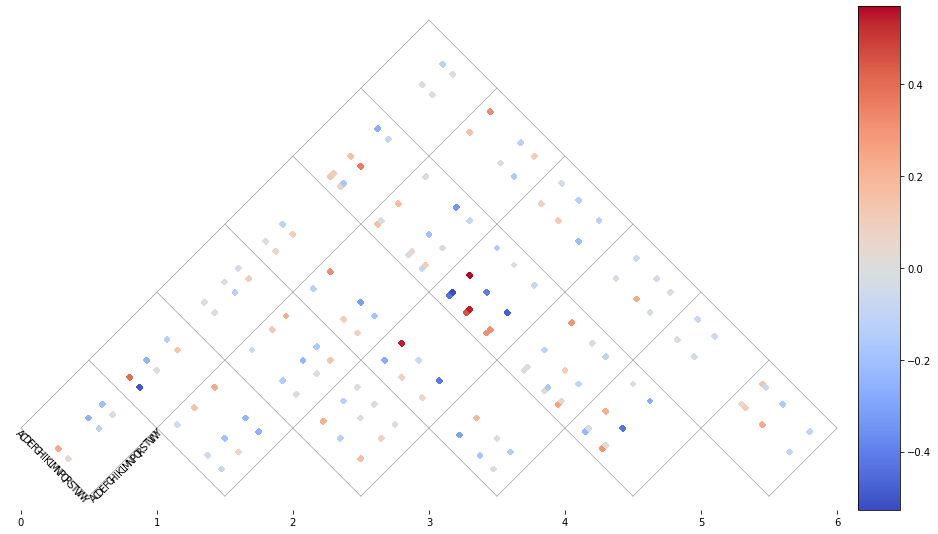

In [41]:
##Loading Bk79 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bk79')
print(train_set)
model = Train_model(train_set,test_set,0.1)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Bk79_epi')
#model = mavenn.load('../result/Bk79_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis
data = theta['theta_lclc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bk79_epi.csv')
print(epi_df)

<ipython-input-21-da1dd33414cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain         pI  rep1_fit  rep2_fit       fit         y  \
0     2445  NDRNEDL  Bei89   4.050028  1.467414  2.506714  1.987064  0.686658   
1     2337  KDKNKKS  Bei89  10.001383  0.123525  0.087467  0.105496 -2.249084   
2     2309  KDRGKTS  Bei89   9.994292  0.027619  0.092054  0.059836 -2.816142   
3     2520  NDRNKES  Bei89   6.069745  0.949164  0.552231  0.750697 -0.286753   
4     2074  NNENKTL  Bei89   6.001425  0.591877  0.318425  0.455151 -0.787126   
..     ...      ...    ...        ...       ...       ...       ...       ...   
686   2394  KDRNEKS  Bei89   8.589977  0.393911  0.139184  0.266547 -1.322204   
687   1774  NNEGKKS  Bei89   8.591073  0.134015  0.120311  0.127163 -2.062287   
688   1917  NNRSETL  Bei89   6.002107  0.269306  0.302209  0.285758 -1.252611   
689   2364  NDRGKDL  Bei89   5.960444  0.394506  0.512943  0.453724 -0.790265   
690   2334  NSRGEES  Bei89   4.531398  1.491371  1.194335  1.342853  0.294796   

       set  
0    train  
1

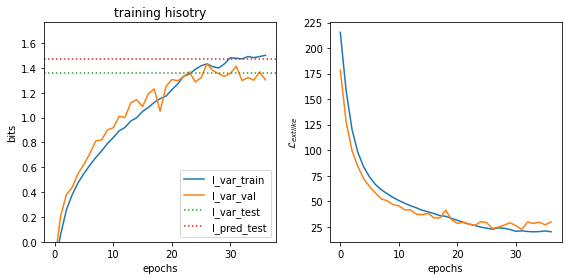

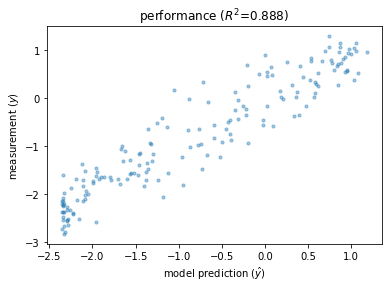

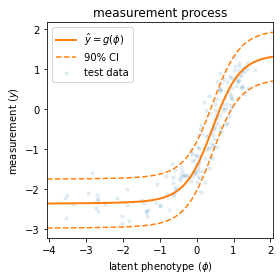

Model saved to these files:
	../result/Bei89_epi.pickle
	../result/Bei89_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.038763
1    1.0  2.0   K   N -0.035467
2    1.0  2.0   K   S -0.004757
3    1.0  2.0   N   D  0.031135
4    1.0  2.0   N   N -0.056525
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.009630
149  6.0  7.0   K   L -0.114899
150  6.0  7.0   K   S -0.130024
151  6.0  7.0   T   L -0.060249
152  6.0  7.0   T   S -0.059044

[153 rows x 5 columns]


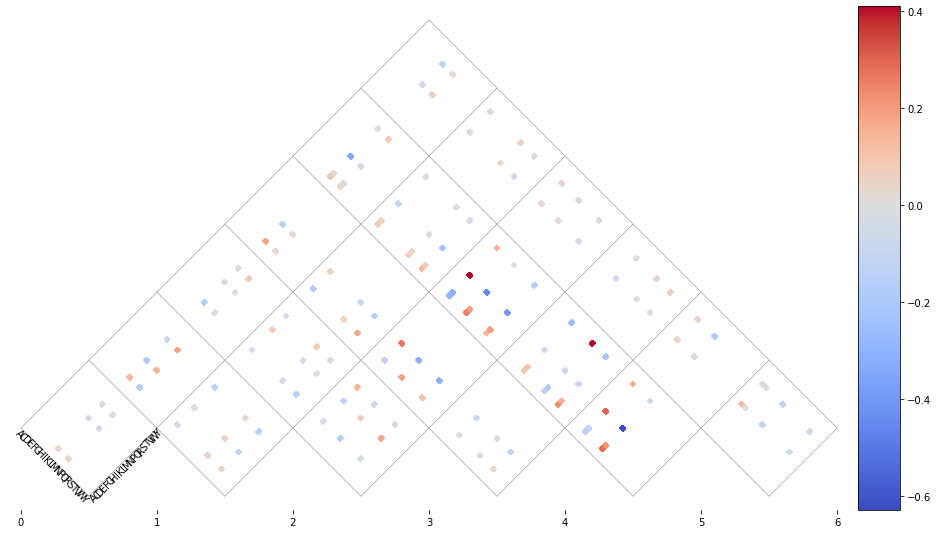

In [42]:
##Loading Bei89 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89')
print(train_set)
model = Train_model(train_set,test_set,0.8)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Bei89_epi')
#model = mavenn.load('../result/Bei89_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis
data = theta['theta_lclc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bei89_epi.csv')
print(epi_df)

<ipython-input-21-da1dd33414cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain         pI  rep1_fit  rep2_fit       fit         y  \
0     2779  NSESKKS  Mos99   8.591073  0.102069  0.202647  0.152358 -1.881521   
1     2641  KSKSKKL  Mos99  10.477740  0.084091  0.095402  0.089747 -2.410766   
2     3027  KNRSEKS  Mos99   9.994292  0.177297  0.291732  0.234514 -1.450238   
3     3082  KDKSEDS  Mos99   4.558112  1.444961  1.331826  1.388394  0.328148   
4     2944  KNRSETL  Mos99   8.747860  1.823729  1.002839  1.413284  0.345916   
..     ...      ...    ...        ...       ...       ...       ...       ...   
686   2659  NNKNKDL  Mos99   8.590944  0.447668  0.593456  0.520562 -0.652846   
687   2769  NSRGEEL  Mos99   4.531398  0.730935  1.885295  1.308115  0.268587   
688   3087  KSRNKDS  Mos99   9.994292  0.143326  0.175548  0.159437 -1.836109   
689   2706  KSENETS  Mos99   4.531398  0.986834  1.327170  1.157002  0.145832   
690   2749  KDKNKKL  Mos99  10.001383  0.081682  0.124256  0.102969 -2.273329   

       set  
0      val  
1

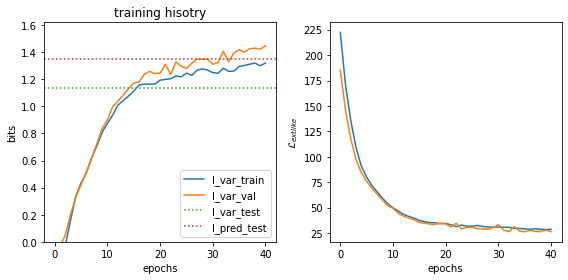

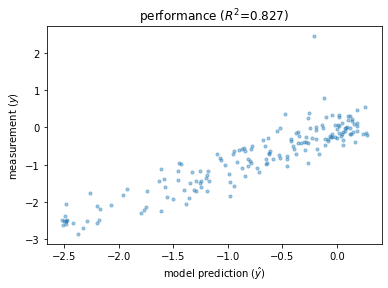

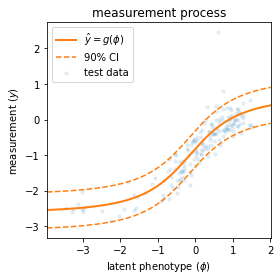

Model saved to these files:
	../result/Mos99_epi.pickle
	../result/Mos99_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.031414
1    1.0  2.0   K   N -0.008612
2    1.0  2.0   K   S -0.075164
3    1.0  2.0   N   D  0.070109
4    1.0  2.0   N   N -0.012775
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.010763
149  6.0  7.0   K   L  0.057230
150  6.0  7.0   K   S -0.088331
151  6.0  7.0   T   L  0.114606
152  6.0  7.0   T   S  0.129328

[153 rows x 5 columns]


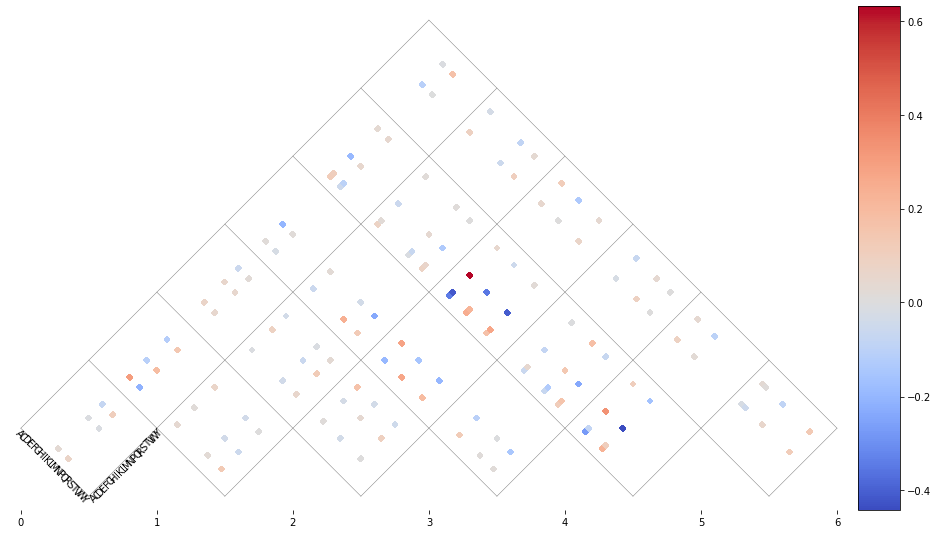

In [24]:
##Loading Mos99 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Mos99')
print(train_set)
model = Train_model(train_set,test_set,0.8)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Mos99_epi')
#model = mavenn.load('../result/Mos99_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis
data = theta['theta_lclc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Mos99_epi.csv')
print(epi_df)

<ipython-input-21-da1dd33414cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain         pI  rep1_fit  rep2_fit       fit         y  \
0     3526  NNKNKTL  Vic11  10.002737  0.206637  0.234125  0.220381 -1.512398   
1     4077  NNKNEDS  Vic11   4.370259  0.646752  0.677375  0.662063 -0.412394   
2     3575  NDRSETS  Vic11   4.370259  1.251792  0.495415  0.873604 -0.135129   
3     3696  KDRNEES  Vic11   4.679122  0.880169  1.747574  1.313872  0.272978   
4     3793  KNRGEEL  Vic11   6.143238  0.159096  0.259119  0.209107 -1.564908   
..     ...      ...    ...        ...       ...       ...       ...       ...   
686   4183  KDKSEDL  Vic11   4.558112  1.395087  0.893700  1.144394  0.134875   
687   3907  KSKNEKS  Vic11   9.703024  0.267259  0.432798  0.350028 -1.049742   
688   3894  NNENEKL  Vic11   4.531398  0.784410  1.017498  0.900954 -0.104301   
689   4063  NDENKES  Vic11   4.137390  0.206115  0.249477  0.227796 -1.479304   
690   4160  NNKGETL  Vic11   6.001425  0.128536  0.185236  0.156886 -1.852236   

       set  
0    train  
1

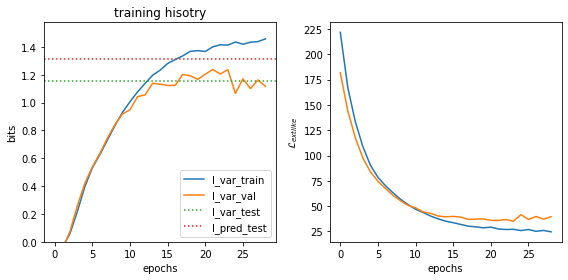

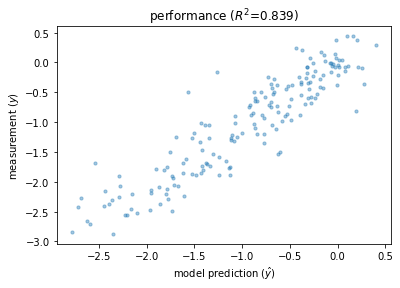

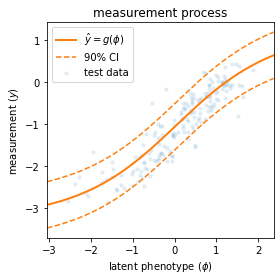

Model saved to these files:
	../result/Vic11_epi.pickle
	../result/Vic11_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.032786
1    1.0  2.0   K   N -0.092267
2    1.0  2.0   K   S -0.079873
3    1.0  2.0   N   D -0.142443
4    1.0  2.0   N   N  0.093102
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.018216
149  6.0  7.0   K   L -0.078705
150  6.0  7.0   K   S -0.025630
151  6.0  7.0   T   L -0.039411
152  6.0  7.0   T   S  0.142547

[153 rows x 5 columns]


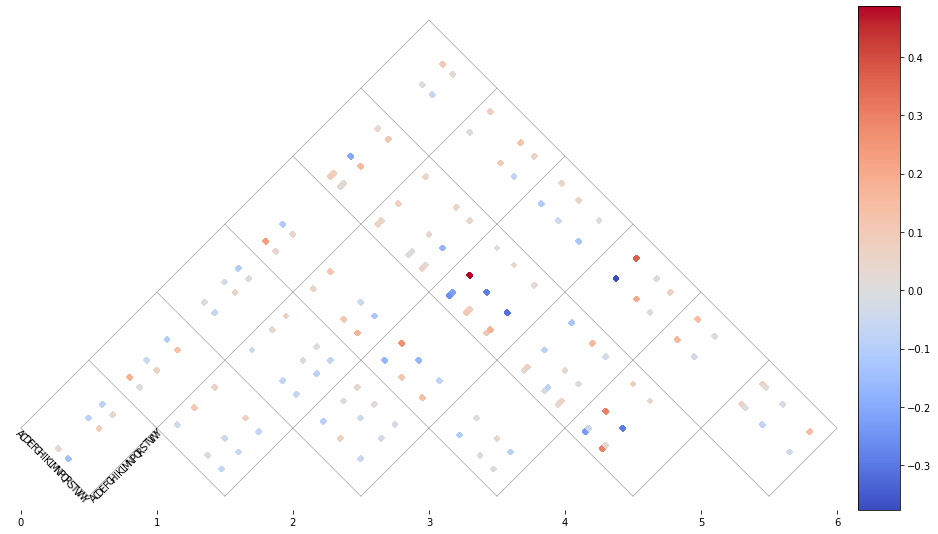

In [29]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Vic11')
print(train_set)
model = Train_model(train_set,test_set,0.8)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis
data = theta['theta_lclc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Vic11_epi.csv')
print(epi_df)

<ipython-input-21-da1dd33414cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain         pI  rep1_fit  rep2_fit       fit         y  \
0     4930  NNRSEDL   HK19   4.370259  0.296659  0.348720  0.322690 -1.131065   
1     4759  KSKGEES   HK19   6.142556  0.934095  2.029221  1.481658  0.393161   
2     5050  KNENETS   HK19   4.531398  0.432465  1.604964  1.018715  0.018542   
3     4926  NSRGEES   HK19   4.531398  0.349883  0.541036  0.445460 -0.808648   
4     4949  KNKGKKS   HK19  10.477740  0.093815  0.102402  0.098109 -2.321680   
..     ...      ...    ...        ...       ...       ...       ...       ...   
686   5092  KNKGKTL   HK19  10.302064  0.144440  0.120564  0.132502 -2.021158   
687   5165  KNKGKTS   HK19  10.302064  0.189559  0.128225  0.158892 -1.839532   
688   4541  KSESKTL   HK19   8.591073  0.401818  0.241984  0.321901 -1.133512   
689   4816  NSKNKTS   HK19  10.002737  0.150397  0.210244  0.180321 -1.713018   
690   5067  KDKSETS   HK19   6.069006  2.186471  5.842448  4.014459  1.389903   

       set  
0    train  
1

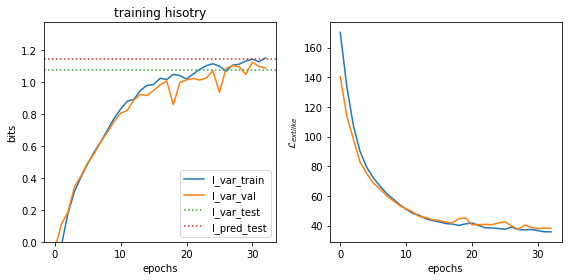

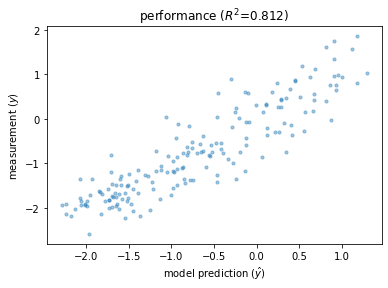

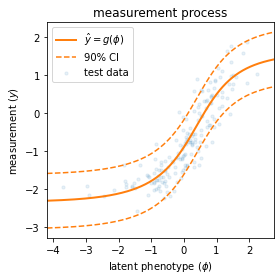

Model saved to these files:
	../result/HK19_epi.pickle
	../result/HK19_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.068789
1    1.0  2.0   K   N -0.089170
2    1.0  2.0   K   S -0.053601
3    1.0  2.0   N   D -0.108032
4    1.0  2.0   N   N  0.066767
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.049425
149  6.0  7.0   K   L -0.097795
150  6.0  7.0   K   S -0.038598
151  6.0  7.0   T   L -0.093630
152  6.0  7.0   T   S  0.121932

[153 rows x 5 columns]


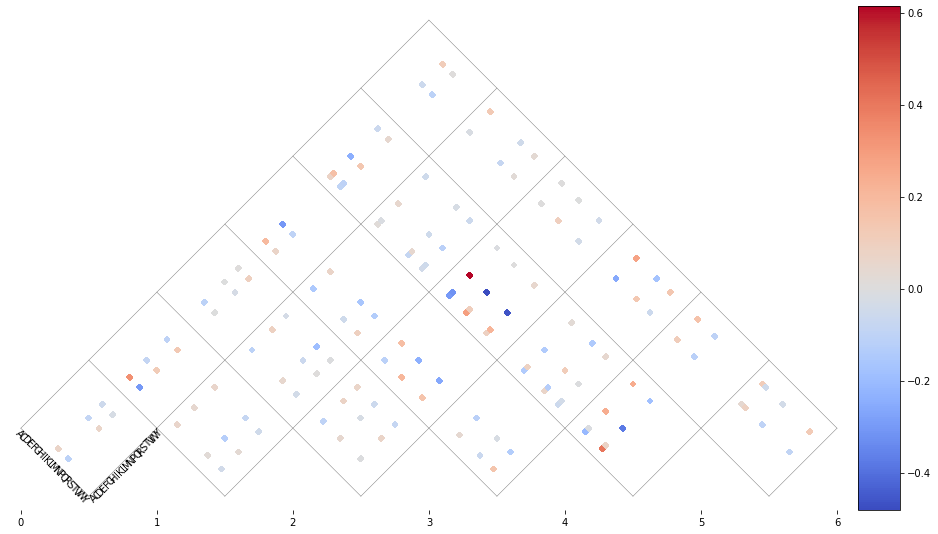

In [31]:
##Loading HK19 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19')
print(train_set)
model = Train_model(train_set,test_set,0.5)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/HK19_epi')
#model = mavenn.load('../result/HK19_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis
data = theta['theta_lclc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HK19_epi.csv')
print(epi_df)